In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [2]:
df = pd.read_csv("Mental Health dataset1.csv")

if "SocialWeakness.1" in df.columns:
    df = df.drop(columns=["SocialWeakness.1"])

df = df.dropna(subset=["SelfEmployed"])

df["Gender"] = df["Gender"].astype(str).str.lower().str.strip()
df["Gender"] = df["Gender"].replace({
    "male": "male", "m": "male", "man": "male",
    "female": "female", "f": "female", "woman": "female"
})
df["Gender"] = df["Gender"].where(df["Gender"].isin(["male", "female"]), "other")

df.head()

,Gender,Country,Occupation,SelfEmployed,FamilyHistory,Treatment,DaysIndoors,HabitsChange,MentalHealthHistory,IncreasingStress,MoodSwings,SocialWeakness,CopingStruggles,WorkInterest,MentalHealthInterview,CareOptions
0,female,UK,Others,No,Yes,No,15-30 days,No,Yes,Yes,High,No,Yes,Maybe,No,No
1,female,USA,Housewife,No,Yes,No,15-30 days,Maybe,Maybe,Yes,High,Maybe,Yes,Maybe,No,Not sure
2,female,Canada,Others,No,No,Yes,More than 2 months,Maybe,No,No,Medium,No,No,No,No,Not sure
3,female,Canada,Corporate,No,Yes,Yes,Go out Every day,No,Maybe,No,Medium,No,No,Maybe,No,Not sure
4,female,UK,Corporate,No,No,Yes,More than 2 months,Yes,No,Maybe,Medium,Maybe,No,Maybe,No,Not sure


In [3]:
lca_features = [
    "Occupation",
    "Gender",
    "Country",
    "SelfEmployed",
    "FamilyHistory",
    "DaysIndoors"
]

ct = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), lca_features)
    ],
    remainder="drop"
)

n_classes = 3

lca_model = Pipeline(steps=[
    ("encoder", ct),
    ("gmm", GaussianMixture(n_components=n_classes, random_state=42))
])

lca_model.fit(df)

encoded = lca_model["encoder"].transform(df)
df["LatentClass"] = lca_model["gmm"].predict(encoded)

print("Latent class counts:")
print(df["LatentClass"].value_counts())


/Users/Daniela.Valdez/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/Daniela.Valdez/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/Daniela.Valdez/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/Daniela.Valdez/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/Daniela.Valdez/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/Daniela.Valdez/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sa

Latent class counts:
LatentClass
1    147314
0     79688
2     29970
Name: count, dtype: int64


In [4]:
outcomes = [
    "HabitsChange",
    "MentalHealthHistory",
    "IncreasingStress",
    "SocialWeakness",
    "MoodSwings"
]

def to_binary(col):
    col = col.astype(str).str.lower()
    return col.apply(
        lambda x: 1 if x.startswith(("yes", "y", "often", "high", "frequent")) else 0
    )

for o in outcomes:
    df[o + "_bin"] = to_binary(df[o])

vars_to_plot = [o + "_bin" for o in outcomes]

mean_symptoms = df.groupby("LatentClass")[vars_to_plot].mean()

overall_means = mean_symptoms.mean(axis=1)
ordered_classes = overall_means.sort_values().index.tolist()
print("Classes ordered by symptom level (low -> high):", ordered_classes)

class_props = df["LatentClass"].value_counts(normalize=True).sort_index()

class_names = {}
labels_in_order = ["Low-symptom group", "Moderate-risk group", "High-symptom group"]

for idx, latent_class in enumerate(ordered_classes):
    prop_pct = class_props[latent_class] * 100
    label = f"{labels_in_order[idx]} ({prop_pct:.1f}%)"
    class_names[latent_class] = label

df["ClassName"] = df["LatentClass"].map(class_names)

print("\nClass labels:")
for k, v in class_names.items():
    print(f"LatentClass {k}: {v}")


Classes ordered by symptom level (low -> high): [0, 1, 2]

Class labels:
LatentClass 0: Low-symptom group (31.0%)
LatentClass 1: Moderate-risk group (57.3%)
LatentClass 2: High-symptom group (11.7%)


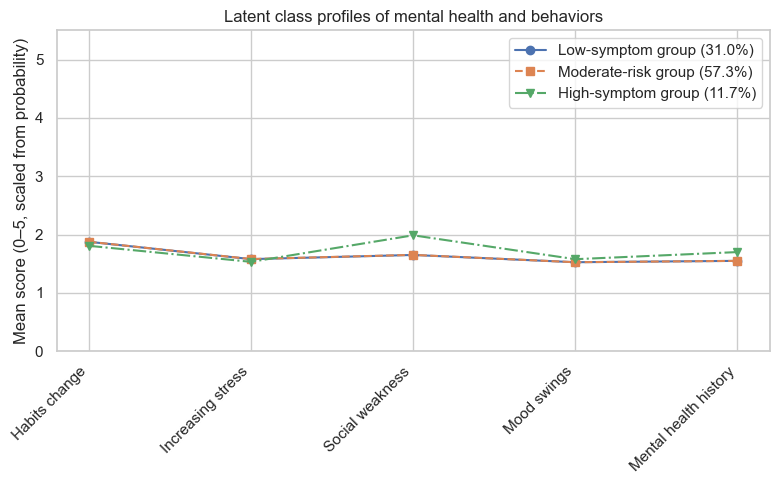

In [5]:
var_labels = [
    "Habits change",
    "Increasing stress",
    "Social weakness",
    "Mood swings",
    "Mental health history"
]

scale_factor = 5.0
mean_matrix = mean_symptoms.loc[ordered_classes].values * scale_factor

x = np.arange(len(var_labels))

plt.figure(figsize=(8, 5))

markers = ["o", "s", "v"]
linestyles = ["-", "--", "-."]

for i, latent_class in enumerate(ordered_classes):
    plt.plot(
        x,
        mean_matrix[i],
        marker=markers[i % len(markers)],
        linestyle=linestyles[i % len(linestyles)],
        label=class_names[latent_class]
    )

plt.xticks(x, var_labels, rotation=45, ha="right")
plt.ylabel("Mean score (0–5, scaled from probability)")
plt.ylim(0, 5.5)
plt.title("Latent class profiles of mental health and behaviors")
plt.legend()
plt.tight_layout()
plt.show()

High-symptom class is: 2 -> High-symptom group (11.7%)


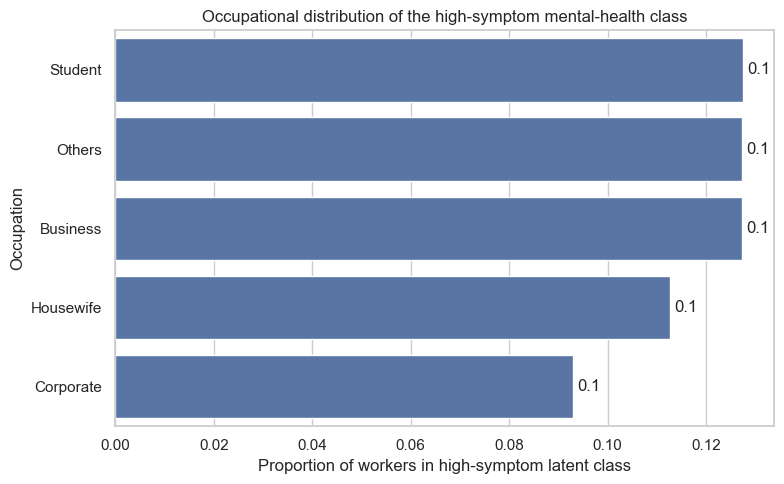

Occupation
Student      0.127392
Others       0.127316
Business     0.127222
Housewife    0.112665
Corporate    0.092931
Name: count, dtype: float64

In [6]:
high_symptom_class = ordered_classes[-1]
print("High-symptom class is:", high_symptom_class, "->", class_names[high_symptom_class])

occ_total = df["Occupation"].value_counts()

occ_high = df.loc[df["LatentClass"] == high_symptom_class, "Occupation"].value_counts()

occ_prop = (occ_high / occ_total).dropna().sort_values(ascending=False)

top_n = 10
occ_prop_top = occ_prop.head(top_n)

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=occ_prop_top.values, y=occ_prop_top.index)

try:
    ax.bar_label(ax.containers[0], fmt="%.1f", padding=3)
except Exception:
    pass 

plt.xlabel("Proportion of workers in high-symptom latent class")
plt.ylabel("Occupation")
plt.title("Occupational distribution of the high-symptom mental-health class")
plt.tight_layout()
plt.show()

occ_prop_top

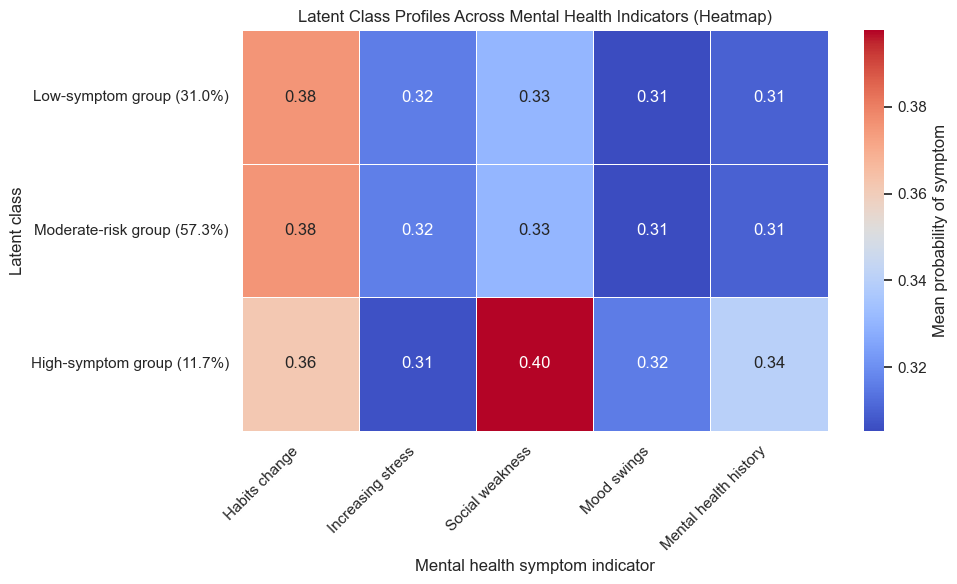

In [7]:
plt.figure(figsize=(10, 6))

sns.heatmap(
    mean_symptoms.loc[ordered_classes],      
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    fmt=".2f",
    cbar_kws={"label": "Mean probability of symptom"}
)

plt.xlabel("Mental health symptom indicator")
plt.ylabel("Latent class")
plt.title("Latent Class Profiles Across Mental Health Indicators (Heatmap)")

plt.xticks(ticks=np.arange(len(vars_to_plot)) + 0.5, labels=var_labels, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(ordered_classes)) + 0.5, labels=[class_names[c] for c in ordered_classes], rotation=0)

plt.tight_layout()
plt.show()